In [98]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [99]:
bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/rotation/25h9/s_yaw_25h9_5m_1080_20.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60]

In [100]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [101]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,13.709139
1,0.938572,2.132727
2,1.727696,3.659391
3,2.644876,5.988475
4,3.340722,4.396463
...,...,...
225,80.834277,55.648722
226,81.156421,55.514425
227,81.417154,55.660238
228,81.673920,58.731398


<AxesSubplot:xlabel='relative_time'>

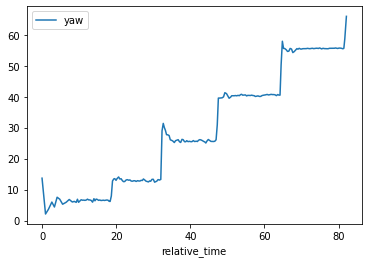

In [102]:
# initial graph
df.plot(x='relative_time', y=target)

In [103]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 2)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [104]:
# the amount of data points we are left with
len(x[peaks])

56

In [105]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

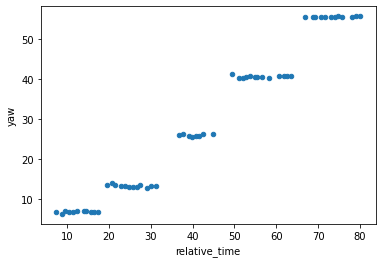

In [106]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [107]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.qcut(df_filtered_by_targets[target], len(input_vals), labels=input_vals)
len(df_filtered_by_targets)

56

In [108]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [110]:
# remove huge errors because theyre actually wrongly binned
df_filtered_by_targets = df_filtered_by_targets.drop(df_filtered_by_targets[df_filtered_by_targets['error'].abs()>10].index)

In [111]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [93]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,yaw,true_yaw,error
9,7.333868,6.821587,0,-6.821587
11,8.692338,6.209786,0,-6.209786
44,19.618834,13.555171,15,1.444829
47,20.656810,14.099255,15,0.900745
95,36.722359,26.143787,30,3.856213
98,37.748480,26.251359,30,3.748641
132,49.320809,41.330024,45,3.669976
142,52.861372,40.466743,45,4.533257
183,66.931164,55.630396,60,4.369604
188,68.756587,55.568656,60,4.431344


In [94]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,11.0,-6.740988,0.235571,-7.076898,-6.915945,-6.735646,-6.636577,-6.209786
15,11.0,1.690153,0.348813,0.900745,1.512229,1.749176,1.918254,2.114709
30,8.0,4.036976,0.256569,3.748641,3.829073,4.001646,4.221296,4.382954
45,10.0,4.279409,0.250866,3.669976,4.215626,4.280472,4.451668,4.536090
60,11.0,4.313608,0.062052,4.226510,4.269729,4.330415,4.340873,4.431344


In [95]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

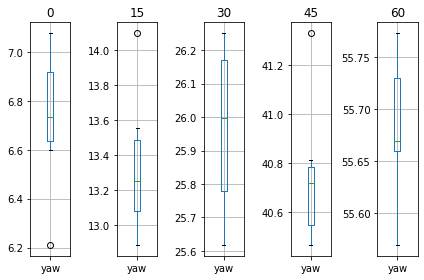

In [96]:
box_plotter(target)

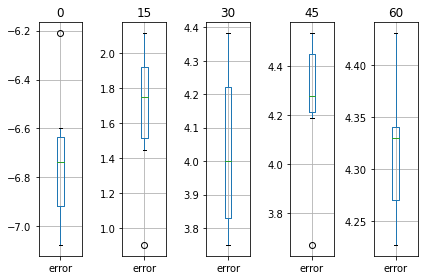

In [97]:
box_plotter('error')